# Tugas Besar B
IF3270 Pembelajaran Mesin<br>
Backward Propagation - Mini Batch Gradient Descent

Developed by:
1. K01 13520010 - Ken Kalang Al Qalyubi
2. K01 13520036 - I Gede Arya Raditya Parameswara
3. K02 13520061 - Gibran Darmawan
4. K03 13520119 - Marchotridyo

## Main Program

### Library

In [127]:
import json, math
import networkx as nx
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import random

### Enum

In [128]:
class LayerEnum(Enum):
    INPUT = "input"
    HIDDEN = "hidden"
    OUTPUT = "output"

class ActivationFuncEnum(Enum):
    SIGMOID = "sigmoid"
    LINEAR = "linear"
    RELU = "relu"
    SOFTMAX = "softmax"

### File Utility

In [129]:
class FileUtility:
    @staticmethod
    def import_json(file_name):
        with open(file_name) as json_file:
            return json.load(json_file)

    @staticmethod
    def export_json(file_name, data):
        with open(file_name, 'w') as outfile:
            json.dump(data, outfile)

### Activation

In [130]:
class Activation:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def linear(x):
        return x
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

    @staticmethod
    def derivative_sigmoid(x):
        return Activation.sigmoid(x) * (1 - Activation.sigmoid(x))
    
    @staticmethod
    def derivative_linear( x):
        return 1
    
    @staticmethod
    def derivative_relu( x):
        return 1 if x >= 0 else 0
    
    @staticmethod
    def derivative_softmax( x):
        return -(1 - x)
    

### Layer

In [131]:
class Layer:
    # Layer adalah kelas yang menyimpan sejumlah neutron berikut fungsi aktivasinya
    def __init__(self, neurons: list, type: str, activation_func: str):
        self.__neurons = neurons
        self.__type = type
        self.__activation_func = activation_func

    def display(self):
        print("Layer Type: " + self.__type)
        print("Neurons: ")
        for neuron in self.__neurons:
            neuron.display()

    def add_neuron(self, neuron):
        self.__neurons.append(neuron)

    def get_neurons(self):
        return self.__neurons
    
    def get_type(self):
        return self.__type
    
    def get_activation_func(self):
        return self.__activation_func

### Error Counter

In [132]:
class ErrorCounter:
    @staticmethod
    def sum_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return np.sum((y_true - y_pred) ** 2)

### Neuron

In [133]:
class Neuron:
    def __init__(
        self, 
        layer: Layer,
        weight: list,
    ):
        self.__layer: Layer = layer
        self.__weight: list = weight
        # __temp_weight digunakan untuk menyimpan cummulative perubahan __weight (saat mini-batch)
        self.__temp_weight: list = weight
        self.__net: float = 0.0
        self.__value: float = 0.0
        self.__error_term = 0.0

    def activate(self):
        if self.__layer.get_activation_func() == ActivationFuncEnum.SIGMOID.value:
            self.__value = 1 / (1 + math.exp(-self.__net))
        elif self.__layer.get_activation_func() == ActivationFuncEnum.LINEAR.value:
            self.__value = self.__net
        elif self.__layer.get_activation_func() == ActivationFuncEnum.RELU.value:
            self.__value = max(0, self.__net)
        elif self.__layer.get_activation_func() == ActivationFuncEnum.SOFTMAX.value:
            try:
                layer_neurons: list = self.__layer.get_neurons()
                exp_sum: float = 0.0

                for neuron in layer_neurons:
                    exp_sum += math.exp(neuron.get_net())

                self.__value = math.exp(self.__net) / exp_sum
            except Exception as e:
                self.__value = 0.0

    def set_value(self, value):
        self.__value = value

    def set_net(self, net):
        self.__net = net

    def set_weight(self, index, weight):
        self.__weight[index] = weight

    def set_temp_weight(self, index, weight):
        self.__temp_weight[index] = weight

    def set_error_term(self, error_term):
        self.__error_term = error_term

    def get_value(self):
        return self.__value

    def get_net(self):
        return self.__net

    def get_weight(self, index):
        return self.__weight[index] 
    
    def get_weights(self):
        return self.__weight
    
    def get_temp_weight(self, index):
        return self.__temp_weight[index] 
    
    def get_temp_weights(self):
        return self.__temp_weight
    
    
    def get_error_term(self):
        return self.__error_term

### ANN Graph

In [134]:
class ANNGraph:
    def __init__(self, file_config_path: str):
        # Set file
        self.file_path = file_config_path
        self.config = None

        # Inisialisasi layers
        self.layers: list[Layer] = []

        # Buat graf ANN --> pengisian self.layers
        self.__build_ann_graph()

    def __build_ann_graph(self):
        # Baca .json, masukkan ke config
        self.config = FileUtility.import_json(self.file_path)

        # Baca input pertama: input layer
        input_layer = Layer([], LayerEnum.INPUT.value, "")
        ## Masukkan neuron. Untuk input layer, weightnya dikosongkan karena tidak digunakan dalam kalkulasi
        input_size = self.config["case"]["model"]["input_size"]
        for i in range(input_size):
            neuron = self.__generate_neuron_data(input_layer, {"weights": []})
            input_layer.add_neuron(neuron)
        ## Input layer masuk ke dalam self.layers
        self.layers.append(input_layer)

        # Baca layer-layer selanjutnya
        layers = self.config["case"]["model"]["layers"]
        ## Proses setiap layer
        for i, layer in enumerate(layers):
            # By default, dia HIDDEN kecuali merupakan layer terakhir
            layer_type = LayerEnum.HIDDEN.value
            if i == len(layers) - 1:
                layer_type = LayerEnum.OUTPUT.value

            # Inisialisasi instance layer
            curr_layer = Layer([], layer_type, layer["activation_function"])

            # Memasukkan neuron ke curr_layer
            layer_weights = self.config["case"]["initial_weights"][i]
            ## Proses untuk setiap layer_weight
            for j in range(layer["number_of_neurons"]):
                neuron_weights = []
                # Weight di layout secara vertikal
                for k in range(len(layer_weights)):
                    neuron_weights.append(layer_weights[k][j])
                neuron = self.__generate_neuron_data(curr_layer, {"weights": neuron_weights})
                curr_layer.add_neuron(neuron)

            # Masukkan curr_layer ke self.layers
            self.layers.append(curr_layer)
        
        return

    def __generate_neuron_data(self, layer: Layer, neuron_data):
        # Fungsi ini membuat suatu instance Neuron berdasarkan data yang diberikan pada layer yang diberikan
        weights: list = []

        if (layer.get_type() == LayerEnum.HIDDEN.value or layer.get_type() == LayerEnum.OUTPUT.value):
            weights = neuron_data["weights"]

        return Neuron(layer, weights)
    
    def __forward_propagation(self, input_data: list[float]):
        # Melakukan proses feed forward berdasarkan input_data
        
        # Masukkan dulu data input ke neuron di layer input
        for i in range(len(input_data)):
            # neuron adalah neuron ke-i di input layer (layers[0])
            neuron: Neuron = self.layers[0].get_neurons()[i]
            neuron.set_value(input_data[i])

        # Lakukan proses feed forward: menghitung nilai output di setiap unit (dalam kasus ini menghitung setiap value di setiap neuron)
        for i, layer in enumerate(self.layers):
            # Jika layer merupakan input layer, tidak perlu diproses
            if layer.get_type() == LayerEnum.INPUT.value:
                continue

            previous_layer = self.layers[i - 1]

            # Hitung dulu masing-masing netnya, baru dihitung valuenya
            for neuron in layer.get_neurons():
                # Hitung net
                total = neuron.get_weight(0)

                previous_neurons: list[Neuron] = previous_layer.get_neurons()
                for i, prev_neuron in enumerate(previous_neurons):
                    # i + 1 karena .get_weight(0) adalah bias
                    total += prev_neuron.get_value() * neuron.get_weight(i + 1)

                neuron.set_net(total)
    
            for neuron in layer.get_neurons():
                neuron.activate()

        return
    
    def __backward_propagation(self, target_data: list[float], update = False):
        # Melakukan proses backward propagation berdasarkan target_data

        # Hitung nilai error term untuk setiap neuron di layer output
        output_layer: Layer = self.layers[len(self.layers) - 1]
        output_neurons: list[Neuron] = output_layer.get_neurons()
        ## Assign error_term dari setiap output_neuron
        for j, output_neuron in enumerate(output_neurons):
            # Kalkulasi chain rule
            oj = output_neuron.get_value()
            # Turunan terhadap oj
            ded_doj = -1 * (target_data[j] - oj)
            # Turunan terhadap netj
            doj_dnetj = 0.0
            activation_func = output_layer.get_activation_func()
            if activation_func == ActivationFuncEnum.LINEAR.value:
                doj_dnetj = 1.0
            elif activation_func == ActivationFuncEnum.RELU.value:
                if oj < 0:
                    doj_dnetj = 0
                else:
                    doj_dnetj = 1
            elif activation_func == ActivationFuncEnum.SIGMOID.value:
                doj_dnetj = oj * (1 - oj)
            elif activation_func == ActivationFuncEnum.SOFTMAX.value:
                pass
            # Set error term = -1 * ded_doj * doj_dnetj
            print(f'output: ded_doj = {ded_doj} || doj_dnetj = {doj_dnetj}')
            print(f'error term = {-1 * ded_doj * doj_dnetj}')
            output_neuron.set_error_term(-1 * ded_doj * doj_dnetj)
            pass

        # Hitung nilai error term untuk setiap neuron di layer hidden
        for i in range(len(self.layers) - 2, -1, -1):
            curr_layer: Layer = self.layers[i]

            # Jika ini layer input, pemrosesan selesai
            if curr_layer.get_type() == LayerEnum.INPUT.value:
                break

            curr_neurons: list[Neuron] = curr_layer.get_neurons()
            
            for h, hidden_neuron in enumerate(curr_neurons):
                # Kalkulasi chain rule
                oh = hidden_neuron.get_value()

                # Turunan terhadap net
                ded_dneth = 0.0
                ## Dalam menghitung de_dnet, perlu data next layer
                next_layer: Layer = self.layers[h + 1]
                next_neurons: list[Neuron] = next_layer.get_neurons()
                for next_neuron in next_neurons:
                    # Hitung nilai dari ded_dnetk + dnetk_doh  + doh_dneth
                    ded_dnetk = -1 * next_neuron.get_error_term()
                    dnetk_doh = next_neuron.get_weight(h + 1)
                    doh_dneth = oh * (1 - oh)

                    ded_dneth += ded_dnetk + dnetk_doh + doh_dneth

                print(f'hidden: ded_neth = {ded_dneth}')

                # Set error term = -1 * ded_dneth
                hidden_neuron.set_error_term(-1 * ded_dneth)
        
        # Update bobot!
        learning_rate = self.config["case"]["learning_parameters"]["learning_rate"]
        for i in range(len(self.layers) - 1, -1, -1):
            curr_layer: Layer = self.layers[i]

            # Jika ini layer input, pemrosesan selesai
            if curr_layer.get_type() == LayerEnum.INPUT.value:
                break

            curr_neurons: list[Neuron] = curr_layer.get_neurons()

            # Data previous layer dibutuhkan untuk mendapatkan nilai xji
            prev_layer: Layer = self.layers[i - 1]
            prev_neurons: list[Neuron] = prev_layer.get_neurons()

            for j, neuron in enumerate(curr_neurons):
                weights: list[float] = neuron.get_weights()

                for k in range(len(weights)):
                    # Default case, untuk bias, xji = 1
                    xji = 1
                    
                    if k != 0:
                        # Bukan bias
                        xji = prev_neurons[k - 1].get_value()

                    delta = learning_rate * neuron.get_error_term() * xji

                    # print(f"{learning_rate} >< {neuron.get_error_term()} >< {xji}")
                    # print(f"Melakukan update weight dari {weight} menjadi {weight + delta}")

                    neuron.set_temp_weight(k, neuron.get_temp_weight(k) + delta)

                    if update:
                        print("Update bosku!")
                        neuron.set_weight(k, neuron.get_temp_weight(k))
        
        return
    
    def __train(self):
        # Melakukan pelatihan sampai terminasi tercapai
        iter = 1

        # Ambil nilai-nilai dari config
        max_iteration = self.config["case"]["learning_parameters"]["max_iteration"]
        batch_size = self.config["case"]["learning_parameters"]["batch_size"]
        error_threshold = self.config["case"]["learning_parameters"]["error_threshold"]
        inputs = len(self.config["case"]["input"])

        # Mulai pemrosesan dari pasangan (x, t) pertama
        index = 0
        processed = 0
        self.sum_delta_weight = 0

        while True:
            processed += 1

            input_vector = self.config["case"]["input"][index]
            target_vector = self.config["case"]["target"][index]
            self.__forward_propagation(input_vector)
            # Jika processed % batch_size == 0, artinya mini-batch selesai diproses, lakukan update bobot.
            print(f"processed: {processed} || batch_size: {batch_size}")
            self.__backward_propagation(target_vector, processed % batch_size == 0)

            # Hitung error
            output_layer: Layer = self.layers[len(self.layers) - 1]
            output_neurons: list[Neuron] = output_layer.get_neurons()

            error = 0.0
            if output_layer.get_activation_func() != ActivationFuncEnum.SOFTMAX.value:
                # Hitung dengan rumus 1/2 (tk - ok)^2
                for i, neuron in enumerate(output_neurons):
                    error += ((target_vector[i] - neuron.get_value()) ** 2) / 2

            index += 1

            if index >= inputs:
                # Epoch baru!
                iter += 1
                index = 0
                processed = 0
            
                # Kondisi akhir #1: Mencapai maksimum iterasi
                if iter > max_iteration:
                    print("Max iteration reached!")
                    break

                # Kondisi akhir #2: Error < error_threshold
                if error < error_threshold:
                    print("Error < error threshold!")
                    break

    def show_weights(self):
        # Cetak weight dengan format yang sama dengan final_weights
        weights = []
        for layer in self.layers:
            # Tidak perlu cetak weight dari input layer
            if layer.get_type() == LayerEnum.INPUT.value:
                continue

            layer_weight = []
            for i in range(len(layer.get_neurons()[0].get_weights())):
                level_weight = []
                for neuron in layer.get_neurons():
                    level_weight.append(neuron.get_weight(i))
                layer_weight.append(level_weight)
            weights.append(layer_weight)

        print(weights)
    
    def draw_ann_graph(self):
        # Terminologies:
        # Xi = neuron ke-i di input layer
        # Hij = neuron ke-j di hidden layer ke-i
        # Oi = neuron ke-i di output layer

        G = nx.DiGraph()

        # Proses setiap layer
        for i, layer in enumerate(self.layers):
            if i == 0:
                continue

            prev_layer = self.layers[i - 1]
            prev_prefix = ""
            prefix = ""

            if prev_layer.get_type() == LayerEnum.INPUT.value:
                prev_prefix = "X"
            elif prev_layer.get_type() == LayerEnum.HIDDEN.value:
                prev_prefix = f"H{i - 1}"
            else:
                prev_prefix = "O"
            
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"

            # Tambahkan edge dari setiap neuron di prev_layer ke layer
            for j, _ in enumerate(prev_layer.get_neurons()):
                for k, neuron in enumerate(layer.get_neurons()):
                    if j == 0:
                        print(f"Bobot bias untuk {prefix}{k + 1} = {neuron.get_weight(0)}")
                    G.add_edge(f"{prev_prefix}{j + 1}", f"{prefix}{k + 1}", weight=neuron.get_weight(j + 1))
            
        # Set posisi node graph
        pos = {}
        curr_x = 0
        for i, layer in enumerate(self.layers):
            curr_y = 0

            prefix = ""
            if layer.get_type() == LayerEnum.INPUT.value:
                prefix = "X"
            elif layer.get_type() == LayerEnum.HIDDEN.value:
                prefix = f"H{i}"
            else:
                prefix = "O"
            
            for j, _ in enumerate(layer.get_neurons()):
                pos[f"{prefix}{j + 1}"] = (curr_x, curr_y)
                curr_y += 1

            curr_x += 1

        options = {
            "font_size": 12,
            "node_size": 2000,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 5,
            "width": 5,
        }

        nx.draw_networkx(G, pos, **options)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels, label_pos=0.6)

        ax = plt.gca()
        ax.margins(0.2)
        plt.axis("off")
        plt.show()

    def solve(self):
        self.__train()

## Testing

Bobot bias untuk O1 = 0.1
Bobot bias untuk O2 = 0.3
Bobot bias untuk O3 = 0.2


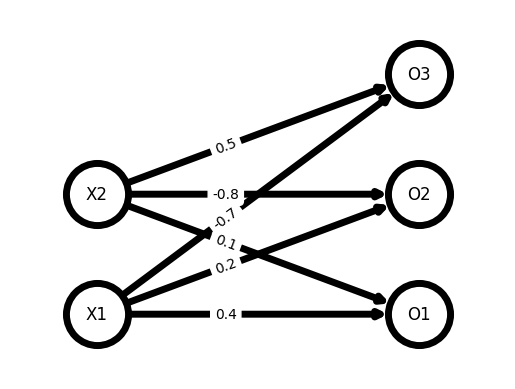

processed: 1 || batch_size: 2
output: ded_doj = -0.5999999999999996 || doj_dnetj = 1.0
error term = 0.5999999999999996
output: ded_doj = -0.1999999999999999 || doj_dnetj = 1.0
error term = 0.1999999999999999
output: ded_doj = 0.5000000000000002 || doj_dnetj = 1.0
error term = -0.5000000000000002
Update bosku!
processed: 2 || batch_size: 2
output: ded_doj = -0.24 || doj_dnetj = 1.0
error term = 0.24
output: ded_doj = -0.28000000000000014 || doj_dnetj = 1.0
error term = 0.28000000000000014
output: ded_doj = 0.09999999999999984 || doj_dnetj = 1.0
error term = -0.09999999999999984
Update bosku!
Max iteration reached!
[[[0.18399999999999997, 0.348, 0.14], [0.604, 0.28800000000000003, -0.8600000000000001], [0.20799999999999996, -0.724, 0.43]]]


In [135]:
graph = ANNGraph("config/linear.json")
graph.draw_ann_graph()
graph.solve()
graph.show_weights()